In [1]:
import os
import pandas as pd
import numpy as np
import ast
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis 
print(os.path.abspath(os.getcwd()))
curr_wd = os.path.abspath(os.getcwd())


/mnt/d/phd/scripts/11_pub_hu-RG-motif-composition_analysis


In [4]:
#### LOADING AND CLEANING THE HUMAN DATASET, AND SAVING A LIST OF ALL HUMAN PROTEINS

### Load FASTA file and extract UniProt identifiers, sequences, and descriptions
with open(curr_wd + '/data/external/UniProt/UP000005640_9606.fasta') as fasta_file:
    identifiers, seqs, desc = [], [], []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):
        identifiers.append(seq_record.id)
        seqs.append(str(seq_record.seq))
        desc.append(seq_record.description)

# Construct dataframe from parsed FASTA entries
pseqs_df = pd.DataFrame({
    'ID': identifiers,
    'sequences': seqs,
    'description': desc
})

# Split UniProt identifier into database, unique identifier, and entry name
pseqs_df[['db', 'UniqueIdentifier', 'EntryName']] = pseqs_df['ID'].str.split('|', expand=True)
pseqs_df.drop(columns='ID', inplace=True)

# Extract gene names from description field, if available
genenames = []
for el in pseqs_df['description']:
    if "GN=" not in el:
        genenames.append("None")
    else:
        temp = el.split(" ")
        for el2 in reversed(temp):
            if el2.startswith("GN="):
                genenames.append(el2[3:])
                break
pseqs_df['gene_name'] = genenames

### Compute amino acid composition, R/G percentages, and sequence length
countdict = []
rperclist, gperclist, ratiolist = [], [], []

for seq in pseqs_df['sequences']:
    analysis = ProteinAnalysis(seq)
    aa_counts = analysis.count_amino_acids()
    aa_perc = analysis.get_amino_acids_percent()

    countdict.append(aa_counts)
    rperclist.append(100 * aa_perc['R'])
    gperclist.append(100 * aa_perc['G'])

    if aa_counts['G'] == 0:
        ratiolist.append(None)
    else:
        ratiolist.append(round(aa_counts['R'] / aa_counts['G'], 3))

# Add computed features to dataframe
pseqs_df['Else'] = countdict  # Full amino acid counts
pseqs_df['length'] = pseqs_df['sequences'].apply(len)
pseqs_df['R%'] = rperclist
pseqs_df['G%'] = gperclist
pseqs_df['R%+G%'] = pseqs_df['R%'] + pseqs_df['G%']
pseqs_df['RtoG_ratio'] = ratiolist

# Remove short sequences (length ≤ 10)
pseqs_df = pseqs_df[pseqs_df['length'] > 10]

### Save list of all unique UniProt identifiers in the human proteome
pseqs_df['UniqueIdentifier'].to_csv(
    curr_wd + '/data/processed/list_of_human_proteins.csv',
    index=False,
    header=False
)


In [11]:
### LOAD AND CLEAN GAR MOTIF DATASET FOR HUMAN PROTEOME

def annotate_RGG_RG_count(setA):
    # Count the occurrences of "RGG" motif in the 'motif' column and store the counts in a new column 'RGG_count'.
    setA['RGG_count'] = setA['motif'].apply(lambda x: x.count("RGG"))
    # Count the occurrences of "RG" motif (without counting the "RGG" occurences in the 'motif' column and store the counts in a new column 'RG_count'.
    setA['RG_count'] = setA['motif'].apply(lambda x: x.count("RG") - x.count("RGG"))
    # Count the occurrences of true "RG" motif in the 'motif' column and store the counts in a new column 'true_RG_count'.
    setA['true_RG_count'] = setA['motif'].apply(lambda x: x.count("RG"))
    
    return setA

# Load motif dataset from Wang et al. (GAR motif finder)
with open(curr_wd + '/data/external/GAR_motif_finder/UP000005640_9606.f.csv', "r") as f:
    tempset3 = pd.read_csv(f)

# Fill down missing accession numbers
for i, e in tempset3.iterrows():
    if pd.isnull(e['Accession number']):
        tempset3.at[i, 'Accession number'] = tempset3.at[i - 1, 'Accession number']

# Extract start and end positions from Position column
tempset3[['start', 'end']] = tempset3['Position'].str.split(r'\.\.', n=1, expand=True)
tempset3['start'] = pd.to_numeric(tempset3['start'])
tempset3['end'] = pd.to_numeric(tempset3['end'])

# Split Accession number into database, unique UniProt ID, and entry name
tempset3[['db', 'UniqueID', 'EntryName']] = tempset3['Accession number'].str.split('|', expand=True)
tempset3['EntryName'] = tempset3['EntryName'].str.split(" ").str[0]

# Calculate motif length
tempset3['length_motif'] = tempset3['end'] - tempset3['start'] + 1

# Parse stringified dictionaries in Else column
tempset3['Else'] = tempset3['Else'].apply(lambda x: ast.literal_eval(str(x)))

# Compute R-to-G ratio within GAR motif
tempset3['r_to_g_ratio'] = tempset3['Gs/Rs in GAR'] ** (-1)

# Rename columns for clarity
tempset3.rename(columns={
    "Pattern": "motif",
    "G%": "g_perc",
    "R%": "r_perc"
}, inplace=True)

# Retrieve full sequences from reference human proteome dataframe
tempset3['full_seq'] = [
    pseqs_df[pseqs_df['UniqueIdentifier'] == uid]['sequences'].tolist()[0]
    for uid in tempset3["UniqueID"].tolist()
]

# Select and reorder relevant columns
set3 = tempset3[[
    'UniqueID', 'EntryName', 'motif', 'r_to_g_ratio',
    'g_perc', 'r_perc', 'start', 'end', 'full_seq', 'Else'
]]

set3 = annotate_RGG_RG_count(set3)

# Save cleaned dataset to CSV and Parquet formats
filepath = curr_wd + '/data/processed/'
set3.to_csv(filepath + 'GAR_motif_Wang_set_human_cleaned.csv', index=False)
set3.to_parquet(filepath + 'GAR_motif_Wang_set_human_cleaned.parquet', index=False)


/tmp/ipykernel_31648/929443928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setA['RGG_count'] = setA['motif'].apply(lambda x: x.count("RGG"))
/tmp/ipykernel_31648/929443928.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setA['RG_count'] = setA['motif'].apply(lambda x: x.count("RG") - x.count("RGG"))
/tmp/ipykernel_31648/929443928.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [10]:
########################################
# AGGREGATE ANNOTATIONS FOR THE ENTIRE HUMAN PROTEOME
# This pre-fetches all data (domains, IDRs, PTMs, GO, LLPS) to avoid repeated lookups later.
########################################

import os
import pandas as pd
import numpy as np
from ast import literal_eval
from feature_annotations import annot_domains, annot_PTMs, annot_IDR, annot_GO, annot_ELM

# Paths
annot_path = curr_wd + '/data/processed/annotation_datasets/'
os.makedirs(annot_path + "failed_requests", exist_ok=True)

# Load list of UniProt IDs
protein_list = pd.read_csv(
    curr_wd + '/data/processed/list_of_human_proteins.csv',
    header=None,
    names=["UniqueID"]
)['UniqueID'].tolist()

##### DOMAINS #####
failed_attempts, annotated_domains_df = annot_domains(
    protein_list, return_failed_attempts=True, show_progress=True
)
annotated_domains_df.to_csv(annot_path + "all_domains_human.csv", index=False)
annotated_domains_df.to_parquet(annot_path + "all_domains_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/domains_human_failed_requests.csv", index=False)

# RUNTIME: ~1h

##### IDRs #####
failed_attempts, annotated_IDR_df = annot_IDR(
    protein_list, return_failed_attempts=True, show_progress=True
)
annotated_IDR_df.to_csv(annot_path + "all_IDR_human.csv", index=False)
annotated_IDR_df.to_parquet(annot_path + "all_IDR_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/IDRs_human_failed_requests.csv", index=False)

# RUNTIME: ~75min

##### PTMs #####
failed_attempts, annotated_PTMs_df = annot_PTMs(
    protein_list, return_failed_attempts=True, show_progress=True, verbose=True
)
annotated_PTMs_df.to_csv(annot_path + "all_PTMs_human.csv", index=False)
annotated_PTMs_df.to_parquet(annot_path + "all_PTMs_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/PTMs_human_failed_requests.csv", index=False)

# RUNTIME: ~86min

##### GO Terms #####
failed_attempts, annotated_GOs_df = annot_GO(
    protein_list, return_failed_attempts=True, show_progress=True, verbose=True
)
annotated_GOs_df.to_csv(annot_path + "all_GO_human.csv", index=False)
annotated_GOs_df.to_parquet(annot_path + "all_GO_human.parquet", index=False)
failed_attempts.to_csv(annot_path + "failed_requests/GO_human_failed_requests.csv", index=False)

# RUNTIME: ~39min

##### LLPS Predictions (PhaSePred) #####
df = pd.read_json(curr_wd + '/data/external/PhasePred/human_reviewed.json')
df = df.T.reset_index().rename(columns={"index": "UniqueID"})
llps_pred_df = df[['UniqueID', 'Sequence', 'PhaSePred']]
llps_pred_df.to_csv(annot_path + "phasepred_human.csv", index=False)

# RUNTIME: ~22 sec


17:05:42 - INFO - Old pandas version detected. Patching DataFrame.map to DataFrame.applymap


0 / 20580 done!
Error accessing UniProt API for protein A0A075B6Y1: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein A0A3B3IRS2: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q5W150: Expecting value: line 1 column 1 (char 0)
Error accessing UniProt API for protein Q5XG85: Expecting value: line 1 column 1 (char 0)


KeyboardInterrupt: 

In [13]:
import pandas as pd
from ast import literal_eval
import numpy as np

# Paths
annot_path = curr_wd + '/data/processed/annotation_datasets/'

# Load annotation datasets
annotated_domains_df = pd.read_csv(annot_path + "all_domains_human.csv")
annotated_IDR_df = pd.read_parquet(annot_path + "all_IDR_human.parquet")
annotated_PTMs_df = pd.read_csv(annot_path + "all_PTMs_human.csv")
annotated_GO_df = pd.read_parquet(annot_path + "all_GO_human.parquet")

llps_pred_df = pd.read_csv(annot_path + "phasepred_human.csv")
llps_pred_df["PhaSePred"] = llps_pred_df["PhaSePred"].apply(literal_eval)

dataset_base_name = "GAR_motif_Wang_set_human"
motif_info_set_df = pd.read_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned.parquet")

##### GO TERMS #####
go_terms_all, go_aspects_all = [], []
invs_RNAbind_all, invs_DNAbind_all, invs_NAbind_all = [], [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_GO_df[annotated_GO_df['UniqueID'] == motif['UniqueID']]

    if curr_df.empty:
        go_terms_all.append([])
        go_aspects_all.append([])
        invs_RNAbind_all.append(0)
        invs_DNAbind_all.append(0)
        invs_NAbind_all.append(0)
        continue

    go_terms_all.append(curr_df["go_terms"].iloc[0])
    go_aspects_all.append(curr_df["go_aspects"].iloc[0])
    invs_RNAbind_all.append(curr_df["invs_RNAbind"].iloc[0])
    invs_DNAbind_all.append(curr_df["invs_DNAbind"].iloc[0])
    invs_NAbind_all.append(curr_df["invs_NAbind"].iloc[0])

motif_info_set_df['go_terms'] = go_terms_all
motif_info_set_df['go_aspects'] = go_aspects_all
motif_info_set_df['invs_RNAbind'] = invs_RNAbind_all
motif_info_set_df['invs_DNAbind'] = invs_DNAbind_all
motif_info_set_df['invs_NAbind'] = invs_NAbind_all

##### DOMAINS #####
part_of_domains, domain_names, domain_go, domain_distance = [], [], [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_domains_df[annotated_domains_df['protein_name'] == motif['UniqueID']]
    part_temp, names_temp, go_temp, dist_temp = [], [], [], []

    for _, domain in curr_df.iterrows():
        names_temp.append(domain["name"])
        go_temp.append(domain["GO_identifiers"])

        if ((domain["start"] >= motif["start"] and domain["end"] <= motif["end"]) or
            (motif["start"] >= domain["start"] and motif["end"] <= domain["end"])):
            part_temp.append(True)
            dist_temp.append(None)
        else:
            part_temp.append(False)
            if domain["start"] < motif["start"]:
                dist_temp.append(domain["end"] - motif["start"])
            else:
                dist_temp.append(domain["start"] - motif["end"])

    part_of_domains.append(part_temp)
    domain_names.append(names_temp)
    domain_go.append(go_temp)
    domain_distance.append(dist_temp)

motif_info_set_df['part_of_domains'] = part_of_domains
motif_info_set_df['domain_names'] = domain_names
motif_info_set_df['domain_go'] = domain_go
motif_info_set_df['domain_distance'] = domain_distance

##### IDRs #####
IDR_position_temp, IDR_overlap_temp = [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_IDR_df[annotated_IDR_df['protein_name'] == motif['UniqueID']]

    if curr_df.empty:
        # print("weirder fall, wo der eintrag nicht existiert")
        # print(motif["UniqueID"])
        IDR_overlap_temp.append(np.nan)
        IDR_position_temp.append(np.nan)
        continue

    seq = curr_df['prediction-disorder-mobidb_lite'].iloc[0]

    if len(seq) <= motif['end']:
        # print("weirder fall, wo die list zu lang oder zu kurz ist???")
        # print(motif["UniqueID"])
        IDR_overlap_temp.append(np.nan)
        IDR_position_temp.append(np.nan)
        continue

    tempslice = seq[motif['start']:motif['end']]
    motif_middle = motif["start"] + len(motif['motif']) // 2

    if sum(tempslice) == len(tempslice):
        IDR_overlap_temp.append("yes")
        count_right = next((j for j in range(1, len(seq) - motif_middle)
                            if seq[motif_middle + j] != 1), len(seq) - motif_middle) - 1
        count_left = next((k for k in range(1, motif_middle)
                           if seq[motif_middle - k] != 1), motif_middle) - 1
        IDR_position_temp.append((count_right - count_left) / (count_left + count_right))
    elif sum(tempslice) > 0:
        IDR_overlap_temp.append("partial")
        if tempslice[0] == 1:
            IDR_position_temp.append(-1)
        elif tempslice[-1] == 1:
            IDR_position_temp.append(1)
        else:
            IDR_position_temp.append(0)
    else:
        IDR_overlap_temp.append("no")
        IDR_position_temp.append(None)

print("IDRs done!")
motif_info_set_df['IDR_overlap'] = IDR_overlap_temp
motif_info_set_df['IDR_position'] = IDR_position_temp

##### PTMs #####
PTM_names, PTM_distance, PTM_players, PTM_type = [], [], [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = annotated_PTMs_df[annotated_PTMs_df['protein_name'] == motif['UniqueID']]
    names_temp, dist_temp, players_temp, type_temp = [], [], [], []

    for _, ptm in curr_df.iterrows():
        names_temp.append(ptm["ptm"])
        if ptm['pos'] < motif['start']:
            dist_temp.append(ptm["pos"] - motif['start'])
        elif ptm["pos"] < motif["end"]:
            dist_temp.append(0)
        else:
            dist_temp.append(ptm["pos"] - motif['end'])
        players_temp.append(ptm['by'])
        type_temp.append(ptm['type'])

    PTM_names.append(names_temp)
    PTM_distance.append(dist_temp)
    PTM_players.append(players_temp)
    PTM_type.append(type_temp)

motif_info_set_df['PTM_names'] = PTM_names
motif_info_set_df['PTM_distance'] = PTM_distance
motif_info_set_df['PTM_players'] = PTM_players
motif_info_set_df['PTM_type'] = PTM_type

##### LLPS #####
llps_pred_score, llps_pred_rank = [], []

for _, motif in motif_info_set_df.iterrows():
    curr_df = llps_pred_df[llps_pred_df['UniqueID'] == motif['UniqueID']]
    if not curr_df.empty:
        llps_pred_score.append(curr_df["PhaSePred"].iloc[0]['SaPS-8fea'])
        llps_pred_rank.append(curr_df["PhaSePred"].iloc[0]['PdPS-8fea'])
    else:
        llps_pred_score.append(np.nan)
        llps_pred_rank.append(np.nan)

motif_info_set_df['llps_pred_score'] = llps_pred_score
motif_info_set_df['llps_pred_rank'] = llps_pred_rank

# Save final annotated DataFrame
motif_info_set_df.to_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot.parquet", index=False)
motif_info_set_df.to_csv(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot.csv", index=False)


IDRs done!


Removal of Collagen associated proteins
Before: 1050
After: 830


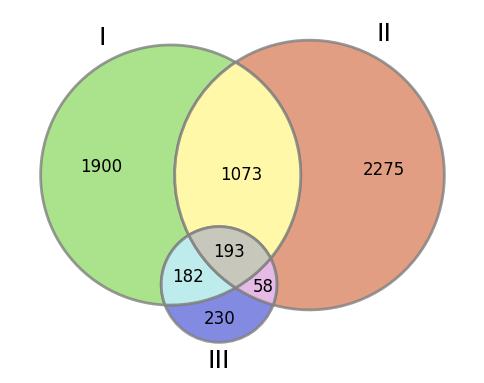

In [8]:
###########################
# Final Venn diagram and group assignment for POS/NEG used in downstream analyses

import os
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

os.makedirs("data/processed/final_set_lists/", exist_ok=True)
final_set_path = curr_wd + '/data/processed/final_set_lists/'

def create_txt_files(true_subset_LLPS, true_subset_NA, GAR_subset, path_name):
    LLPS_positive_set, NA_positive_set, GAR_subset = map(set, [true_subset_LLPS, true_subset_NA, GAR_subset])
    set_collection = []
    set_names_collection = []

    set_collection.append(LLPS_positive_set - NA_positive_set - GAR_subset)
    set_names_collection.append("1_LLPS_positive_set_only")

    set_collection.append(LLPS_positive_set & NA_positive_set - GAR_subset)
    set_names_collection.append("2_LLPS_positive_set_and_NA_positive_set")

    set_collection.append(NA_positive_set - LLPS_positive_set - GAR_subset)
    set_names_collection.append("3_NA_positive_set_only")

    set_collection.append(LLPS_positive_set & GAR_subset - NA_positive_set)
    set_names_collection.append("4_LLPS_positive_set_and_GAR_subset")

    set_collection.append(LLPS_positive_set & NA_positive_set & GAR_subset)
    set_names_collection.append("5_LLPS_positive_set_and_NA_positive_set_and_GAR_subset")

    set_collection.append(NA_positive_set & GAR_subset - LLPS_positive_set)
    set_names_collection.append("6_NA_positive_set_and_GAR_subset")

    set_collection.append(GAR_subset - LLPS_positive_set - NA_positive_set)
    set_names_collection.append("7_GAR_subset_only")

    set_collection.extend([true_subset_LLPS, true_subset_NA, GAR_subset])
    set_names_collection.extend(["LLPS_positive_set_full", "NA_positive_set_full", "GAR_subset_full"])

    for i, sets in enumerate(set_collection):
        with open(path_name + str(set_names_collection[i]) + ".txt", 'w') as fp:
            for item in sets:
                fp.write(f"{item}\n")

# Load and prepare data
motif_info_set_df = pd.read_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot.parquet")

llps_pred_df = pd.read_csv(annot_path + "phasepred_human.csv")

llps_pred_df["PhaSePred"] = llps_pred_df["PhaSePred"].apply(literal_eval)
llps_pred_df["SaPS-8fea"] = [a["SaPS-8fea"] for a in llps_pred_df["PhaSePred"]]
llps_pred_df["PdPS-8fea"] = [a["PdPS-8fea"] for a in llps_pred_df["PhaSePred"]]

annotated_GO_df = pd.read_parquet(annot_path + "all_GO_human.parquet")

true_subset_LLPS = llps_pred_df[llps_pred_df["SaPS-8fea"] > 0.5]["UniqueID"].tolist()
true_subset_RNA = annotated_GO_df[annotated_GO_df["invs_RNAbind"] > 0]["UniqueID"].tolist()
true_subset_DNA = annotated_GO_df[annotated_GO_df["invs_DNAbind"] > 0]["UniqueID"].tolist()
true_subset_NA = annotated_GO_df[annotated_GO_df["invs_NAbind"] > 0]["UniqueID"].tolist()
true_subset = [value for value in true_subset_LLPS if value in true_subset_RNA]

# === Version 2 Filtering: IDR-only, not part of any domain ===
filtered_df = motif_info_set_df[motif_info_set_df['part_of_domains'].apply(lambda x: all(v == False for v in x))]

filtered_df = filtered_df[filtered_df["IDR_overlap"] == "yes"]
# === Version 3: Remove Collagen-associated proteins ===
collagen_file = curr_wd + '/data/external/UniProt/collagen_prots_human.txt'
coll_list_prot = pd.read_csv(collagen_file, sep='\t').Entry.tolist()

print("Removal of Collagen associated proteins")
print("Before:", len(filtered_df["UniqueID"].tolist()))
filtered_df = filtered_df[~filtered_df["UniqueID"].isin(coll_list_prot)]
print("After:", len(filtered_df["UniqueID"].tolist()))

# Save V3 data
temp_filtered_df = filtered_df.reset_index(drop=False)
temp_filtered_df.rename(columns={"index": "orig_motif_index"}, inplace=True)
temp_filtered_df.to_parquet(curr_wd + '/data/processed/' + dataset_base_name + "_cleaned_annot_filtered.parquet")

# Generate and save Venn diagram
GAR_subset = filtered_df["UniqueID"].tolist()
create_txt_files(true_subset_LLPS, true_subset_NA, GAR_subset, final_set_path)

plt.figure(figsize=(6, 6))
venn = venn3([set(true_subset_LLPS), set(true_subset_NA), set(GAR_subset)], set_labels=('I', 'II', 'III'), set_colors=('#96DB70', '#DB8663', '#636DDB'), alpha=0.8)


# plt.figure(figsize=(7, 7))
# venn3([set(true_subset_LLPS), set(true_subset_NA), set(GAR_subset)],
#       ("A", 'B', 'C'), set_colors=['blue', 'red', 'green'])
# venn3_circles([set(true_subset_LLPS), set(true_subset_NA), set(GAR_subset)], linestyle='dotted')
# plt.gcf().savefig(final_set_path + 'GARvsLLPSvsNA_Venn.png', bbox_inches='tight')


# import matplotlib.pyplot as plt
# from matplotlib_venn import venn3

# # Define the subset sizes
# subsets = (1900, 2275, 1073, 230, 182, 58, 193) ##### these values come from the lsits above
# # Create the figure

# # Create the figure
# plt.figure(figsize=(6, 6))
# venn = venn3(subsets=subsets, set_labels=('I', 'II', 'III'), set_colors=('#96DB70', '#DB8663', '#636DDB'), alpha=0.8)

# Customize appearance for publication
for subset in venn.set_labels:
    subset.set_fontsize(18)
    # subset.set_fontweight('bold')

for i in [3]:
    x, y = venn.subset_labels[i].get_position()
    venn.subset_labels[i].set_position((x, y + 0.04))  # Adjust x_offset and y_offset as needed
    # venn.subset_labels[i].set_color("#FF4040")

for i in [4]:
    x, y = venn.subset_labels[i].get_position()
    venn.subset_labels[i].set_position((x+0.02, y - 0.01))  # Adjust x_offset and y_offset as needed

for i in [5]:
    x, y = venn.subset_labels[i].get_position()
    venn.subset_labels[i].set_position((x-0.01, y - 0.01))  # Adjust x_offset and y_offset as needed
    # venn.subset_labels[i].set_color("red")
for i in [6]:
    x, y = venn.subset_labels[i].get_position()
    venn.subset_labels[i].set_position((x-0.01, y - 0.03))  # Adjust x_offset and y_offset as needed
    # venn.subset_labels[i].set_color("#8DB600")

for subset in venn.subset_labels:
    if subset:
        subset.set_fontsize(12)

# Highlight specific regions
# venn.get_label_by_id('111').set_bbox(dict(facecolor='none', edgecolor='green', linewidth=3))  # Center intersection
# venn.get_label_by_id('001').set_bbox(dict(facecolor='none', edgecolor='red', linewidth=3))  # Bottom intersection

# Add dashed outline to circles
for i in [0,1,2,3,6,4,5]:
    patch = venn.patches[i]
    if patch:
        patch.set_edgecolor('grey')
        patch.set_linestyle('solid')
        patch.set_linewidth(2)
# venn.patches[3].set_edgecolor("#FF4040")
# venn.patches[3].set_linewidth(3)
# venn.patches[6].set_edgecolor("#8DB600")
# venn.patches[6].set_linewidth(3)


# Set title
# plt.title("Venn Diagram of Three Sets", fontsize=16, fontweight='bold')

plt.savefig(final_set_path + 'GARvsLLPSvsNA_Venn.png', bbox_inches='tight')
plt.show()


